In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import _pickle as pickle

In [2]:
# load the data and check sequence lengths
with open('train_data.pkl', 'rb') as f:
    data = pickle.load(f,encoding='latin1')
len_vec = []
for i,j in enumerate(data.values()):
    len_vec.append(len(j))
len_vec = np.array(len_vec)

print(np.max(len_vec), np.min(len_vec), np.mean(len_vec))

1480 50 176.22586666666666


In [3]:
# load data into a numpy array with sequence length 50 and save it
mat = []
for i,j in enumerate(data.values()):
    mat.append(j[:50])
mat = np.array(mat)
mat.shape

(7500, 50, 46)

In [4]:
# normalize the data
normalized = np.copy(mat)
normalized[:,:,::2] = normalized[:,:,::2] / 52.5
normalized[:,:,1::2] = normalized[:,:,1::2] / 34

In [5]:
#get distance from ball for each player and store as a matrix
ball_dist = np.copy(normalized)
ball_dist[:,:,::2] = (ball_dist[:,:,::2].T - ball_dist[:,:,-2].T).T
ball_dist[:,:,1::2] = (ball_dist[:,:,1::2].T - ball_dist[:,:,-1].T).T
# get ball distances of players only
ball_dist = ball_dist[:,:,:-2]

In [6]:
# get the velocities
vel = mat[:,1:] - mat[:,:-1]
zero_vec = np.zeros((7500, 1, 46))
vel = np.concatenate((zero_vec, vel), axis=1)
vel.shape
# normalize the player and ball velocities separately
# playervel_mean_x = np.mean(vel[:,:,:-2:2])
# playervel_std_x = np.std(vel[:,:,:-2:2])
# playervel_mean_y = np.mean(vel[:,:,1:-2:2])
# playervel_std_y = np.std(vel[:,:,1:-2:2])
# ballvel_mean_x = np.mean(vel[:,:,-2])
# bellvel_std_x = np.std(vel[:,:,-2])
# ballvel_mean_y = np.mean(vel[:,:,-1])
# bellvel_std_y = np.std(vel[:,:,-1])
# vel[:,:,:-2:2] = (vel[:,:,:-2:2] - playervel_mean_x) / playervel_std_x
# vel[:,:,1:-2:2] = (vel[:,:,1:-2:2] - playervel_mean_y) / playervel_std_y
# vel[:,:,-2] = (vel[:,:,-2] - ballvel_mean_x) / bellvel_std_x
# vel[:,:,-1] = (vel[:,:,-1] - ballvel_mean_y) / bellvel_std_y

(7500, 50, 46)

In [7]:
# concat normalized positions and ball distances into a single vector of length(46+44). This is data for the LSTM
lstm_data = np.concatenate((normalized, ball_dist), axis = 2)
# np.save('lstm_data.npy', lstm_data)
lstm_data.shape

(7500, 50, 90)

In [8]:
# check for instances where player-ball interactions take place i.e. ball_dist = 0
interactions = (ball_dist[:,:,::2] == 0) * (ball_dist[:,:,1::2] == 0)
interactions = np.sum(interactions, axis=2)
interactions = interactions.astype(int)
# np.save('interactions.npy', interactions)
interactions.shape

(7500, 50)

In [12]:
np.arange(7500)[np.sum(interactions,axis=1) == 0]

array([   3,   61,  104,  111,  116,  122,  127,  130,  134,  135,  151,
        190,  202,  222,  244,  249,  267,  272,  289,  302,  306,  329,
        341,  349,  384,  395,  419,  453,  468,  473,  478,  493,  508,
        534,  538,  539,  558,  559,  573,  587,  597,  616,  621,  643,
        651,  666,  674,  684,  691,  704,  712,  753,  762,  788,  789,
        790,  802,  803,  834,  835,  843,  845,  847,  862,  870,  871,
        884,  891,  892,  905,  928,  957,  974,  981, 1015, 1028, 1035,
       1041, 1078, 1094, 1111, 1112, 1123, 1129, 1137, 1159, 1169, 1183,
       1204, 1207, 1210, 1214, 1249, 1299, 1336, 1341, 1343, 1345, 1365,
       1382, 1387, 1389, 1414, 1449, 1453, 1464, 1470, 1477, 1495, 1501,
       1506, 1525, 1611, 1616, 1634, 1637, 1698, 1699, 1716, 1735, 1758,
       1792, 1796, 1818, 1819, 1825, 1856, 1859, 1876, 1905, 1908, 1912,
       1917, 1922, 1931, 1935, 1964, 1966, 1979, 1985, 2029, 2047, 2061,
       2071, 2074, 2083, 2095, 2101, 2111, 2130, 21

In [ ]:
interactions

In [70]:
# data for FCN(same data in a more suitable format)
position_x = normalized[:,:,::2]
position_y = normalized[:,:,1::2]
ball_dist_x = ball_dist[:,:,::2]
ball_dist_y = ball_dist[:,:,1::2]
vel_x = vel[:,:,::2]
vel_y = vel[:,:,1::2]
player_indices = np.zeros((7500,50,22))
player_indices[:,:,:] = np.arange(22)
distances = np.sqrt(ball_dist_x**2 + ball_dist_y**2)
position_x.shape, position_y.shape, ball_dist_x.shape, ball_dist_y.shape, vel_x.shape, vel_y.shape, distances.shape

C:\Users\vishw\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


((7500, 50, 23),
 (7500, 50, 23),
 (7500, 50, 22),
 (7500, 50, 22),
 (7500, 50, 23),
 (7500, 50, 23),
 (7500, 50, 22))

In [71]:
# check the number of players in the context area when player-ball interaction takes place
context = 10 / 34
fcn = []
for i in range(7500):
    for j in range(50):
        if interactions[i,j] > 0:
            fcn.append(np.sum((np.abs(ball_dist_x[i,j,:]) < context) * (np.abs(ball_dist_y[i,j,:]) < context)))
fcn = np.array(fcn)
np.mean(fcn)

6.345671267252196

In [72]:
mask = (np.abs(ball_dist_x) < context) * (np.abs(ball_dist_y) < context)

In [73]:
fcn_data = np.zeros((7500, 50, 44))
prediction_indices = np.zeros((7500, 50))
for i in range(7500):
    for j in range(50):
        if interactions[i,j] > 0:
            insta_ball_dist = distances[i,j][mask[i,j]]
            insta_indices = np.argsort(insta_ball_dist)
            insta_player_indices = player_indices[i,j][mask[i,j]][insta_indices]
            prediction_indices[i,j] = insta_player_indices[0]
            insta_pos_x = normalized[:,:,:-2:2][i,j][mask[i,j]][insta_indices]
            insta_pos_y = normalized[:,:,1:-2:2][i,j][mask[i,j]][insta_indices]        
            insta_ball_x = ball_dist_x[i,j][mask[i,j]][insta_indices]
            insta_ball_y = ball_dist_y[i,j][mask[i,j]][insta_indices]
            insta_velocity_x = vel_x[:,:,:-1][i,j][mask[i,j]][insta_indices]
            insta_velocity_y = vel_y[:,:,:-1][i,j][mask[i,j]][insta_indices]
            fcn_data[i,j,0] = normalized[i,j,-2]
            fcn_data[i,j,1] = normalized[i,j,-1]
            fcn_data[i,j,2] = vel_x[i,j,-1]
            fcn_data[i,j,3] = vel_y[i,j,-1]
            fcn_data[i,j,4] = insta_pos_x[0]
            fcn_data[i,j,5] = insta_pos_y[0]
            fcn_data[i,j,6] = insta_velocity_x[0]
            fcn_data[i,j,7] = insta_velocity_y[0]
            fcn_data[i,j,8] = -1 if insta_player_indices[0] <= 10 else 1
            c = 1
            e = 9
            for d in range(1,len(insta_indices)):
                fcn_data[i,j,e] = insta_pos_x[d]
                fcn_data[i,j,e+1] = insta_pos_y[d]
                fcn_data[i,j,e+2] = insta_ball_x[d]
                fcn_data[i,j,e+3] = insta_ball_y[d]
                fcn_data[i,j,e+4] = insta_velocity_x[d]
                fcn_data[i,j,e+5] = insta_velocity_y[d]
                fcn_data[i,j,e+6] = -1 if insta_player_indices[d] <= 10 else 1
                e += 7
                c += 1
                if c == 6:
                    break
np.save('fcn_data.npy', fcn_data)
prediction_indices = prediction_indices.astype(int)
np.save('prediction_indices', prediction_indices)

In [74]:
fcn_data.shape

(7500, 50, 44)

In [147]:
prediction_indices.astype(int)
prediction_indices

array([[15.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [16.,  0.,  0., ...,  0.,  0.,  0.],
       [17.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [87]:
fcn_data[1234][0]

array([-0.74926829, -0.02089552,  0.        ,  0.        , -0.74926829,
       -0.02089552,  0.        ,  0.        ,  1.        , -0.58731705,
       -0.08358209,  0.16195124, -0.06268656,  0.        ,  0.        ,
        1.        , -0.53463417, -0.19104478,  0.21463412, -0.17014925,
        0.        ,  0.        , -1.        , -0.46048781,  0.0238806 ,
        0.28878048,  0.04477612,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [126]:
ball_dist[interactions > 0][9]

array([ 1.2095695 ,  0.06814815,  0.        , -0.3288889 ,  0.48803827,
        0.33185184,  0.50526315, -0.01481481, -0.02105266, -0.01481481,
        0.24497607, -0.64      ,  0.2124402 , -0.02962963,  0.2124402 ,
       -0.3851852 , -0.17033494, -0.11259259,  0.5033493 , -0.30222222,
        0.15502393, -0.17481482, -0.43827754,  0.05037037, -0.13205737,
        0.00296296, -0.09569377,  0.17481482, -0.04784691, -0.17185184,
       -0.03253591, -0.08888889,  0.37511963, -0.02666666,  0.5167464 ,
        0.3822222 ,  0.32918662, -0.42962962,  0.        ,  0.        ,
       -0.15119618, -0.1362963 , -0.04593301, -0.30222222], dtype=float32)

In [66]:
attacking_players=mat[4,:,:22]
defending_players=mat[4,:,22:44]
balls=mat[4,:,44:]

In [62]:
np.sum(((np.abs(ball_dist[4,:,::2]) < 0.005) * (np.abs(ball_dist[4,:,1::2]) < 0.005)),axis=1)

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0])

In [61]:
ball_dist[3,29,:]

array([ 7.8564596e-01,  5.9970367e-01,  1.1196172e-01, -2.2518516e-02,
        2.3636365e-01,  9.4340742e-01,  3.9234459e-02,  3.6859259e-01,
        1.7703351e-01,  2.6488888e-01,  3.3971292e-01,  9.3037009e-02,
        3.7990433e-01,  2.7674073e-01, -2.0095691e-02,  8.6933333e-01,
        3.9712918e-01,  1.1152592e+00,  1.9999999e-01,  6.0562962e-01,
        3.8947368e-01,  6.0859257e-01, -7.9138756e-01,  6.0266668e-01,
        3.0526316e-01,  1.9081479e-01,  4.1052634e-01,  1.3463703e+00,
        4.1052634e-01,  5.7303703e-01, -2.8708130e-03,  1.1851788e-03,
       -1.8277511e-01,  4.8118517e-01, -1.3110048e-01,  9.3451852e-01,
       -2.0095691e-02,  2.5303704e-01,  1.3301435e-01,  6.5303701e-01,
        1.7511964e-01, -3.3362973e-01,  1.4066988e-01,  3.4192592e-01],
      dtype=float32)

<IPython.core.display.Javascript object>


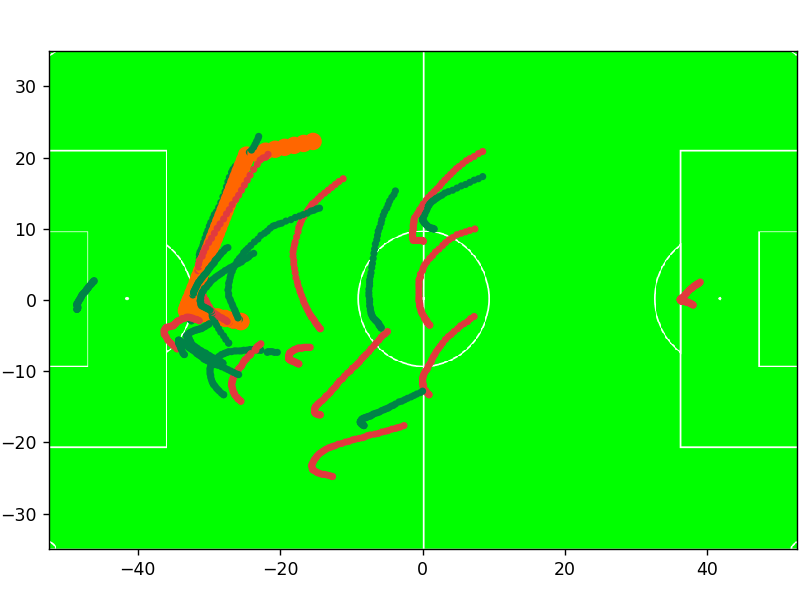

In [67]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

# directories
# CHANGE HERE
data_dir = ''
game_dir = data_dir
court_path = data_dir + 'soccer_field_cropped.png'
fig = plt.figure()
ax = plt.gca() #create axis object
img = mpimg.imread(court_path)  # read image. I got this image from gmf05's github.

plt.imshow(img, extent=[-52.5,52.5,-35,35], zorder=0)
color_dict = {
    'attacking': '#E13A3E',
    'defending': '#008348'
}


def function_to_draw_figure(jj):
  # show the image.

    ball = balls[jj,:].reshape(-1)
    att_player = attacking_players[jj,:].reshape(-1)
    def_player=defending_players[jj,:].reshape(-1)

    for i in range(11):

        xx=att_player[2*i]
        yy=att_player[1+2*i]
        print(xx,yy)
        player_circ_att = plt.Circle((xx,yy),0.5,
                        facecolor=color_dict['attacking'])
        ax.add_artist(player_circ_att)

        xx=def_player[2*i]
        yy=def_player[1+2*i]
        player_circ_def = plt.Circle((xx,yy),0.5,
                        facecolor=color_dict['defending'])
        ax.add_artist(player_circ_def)



    ball_circ = plt.Circle((ball[0], ball[1]),1.1, color=[1, 0.4, 0])  # create circle object for bal
    ax.add_artist(ball_circ)
    plt.xlim([-52.5,52.5])
    plt.ylim([-35,35])

    plt.tight_layout(pad=0, w_pad=0.5, h_pad=0)



ani = FuncAnimation(plt.gcf(), function_to_draw_figure, frames=50, 
                    interval=100, repeat=False)

plt.show()

In [99]:
mat[0,16,:]

array([ 43.1      ,   3.3900294,  29.1      ,  19.04399  ,  12.400001 ,
       -12.762464 ,  23.800001 ,  -2.0938416, -12.3      ,  -7.478006 ,
         0.9      ,   5.184751 ,   0.1      ,  31.208212 ,  -9.200001 ,
         4.3870964,  10.9      ,  23.231672 ,  17.9      ,  30.510263 ,
        -7.2      ,  26.02346  , -41.       ,   8.5747795, -13.7      ,
         7.876833 ,  -2.7      ,  12.56305  ,  -7.1      ,  30.01173  ,
        -0.8      ,  29.812317 ,   3.5000002,  -5.9824047,  21.699999 ,
        21.038124 , -13.3      ,  22.633432 ,  12.7      ,  34.89736  ,
        23.       ,  12.363637 , -12.2      ,  -7.378299 ,  -1.25     ,
        29.71261  ], dtype=float32)

In [77]:
mat[0,1,::2] = mat[0,1,::2] + 1.75
mat[0,1,:]

array([ 4.6049999e+01,  3.0909092e+00,  3.5150002e+01,  1.7847507e+01,
        1.3550000e+01, -1.2762464e+01,  2.9350000e+01, -8.4750729e+00,
       -1.0450000e+01, -7.4780059e+00,  3.7500000e+00,  4.3870964e+00,
       -3.5499997e+00,  3.0111437e+01, -7.2500000e+00,  4.6862173e+00,
        1.5650000e+01,  1.9143696e+01,  2.1150002e+01,  3.1607038e+01,
       -6.2500000e+00,  2.2434019e+01, -3.8950001e+01,  8.1759529e+00,
       -1.2650000e+01,  8.2756596e+00,  5.5000007e-01,  1.0967742e+01,
       -6.8500004e+00,  2.8615835e+01, -4.9999952e-02,  3.0609970e+01,
        7.1500001e+00, -8.4750729e+00,  2.3549999e+01,  2.1337244e+01,
       -1.0450000e+01,  2.0838711e+01,  2.1449999e+01,  3.4498535e+01,
        2.9549999e+01,  1.0967742e+01, -7.4500008e+00, -5.9824047e+00,
       -1.1920929e-07,  3.0280937e+01], dtype=float32)

In [78]:
mat[0,1,1::2] = mat[0,1,1::2] - 30.280937
mat[0,1,:]

array([ 4.6049999e+01, -2.7190027e+01,  3.5150002e+01, -1.2433430e+01,
        1.3550000e+01, -4.3043400e+01,  2.9350000e+01, -3.8756012e+01,
       -1.0450000e+01, -3.7758942e+01,  3.7500000e+00, -2.5893841e+01,
       -3.5499997e+00, -1.6950035e-01, -7.2500000e+00, -2.5594719e+01,
        1.5650000e+01, -1.1137241e+01,  2.1150002e+01,  1.3261013e+00,
       -6.2500000e+00, -7.8469181e+00, -3.8950001e+01, -2.2104984e+01,
       -1.2650000e+01, -2.2005278e+01,  5.5000007e-01, -1.9313194e+01,
       -6.8500004e+00, -1.6651020e+00, -4.9999952e-02,  3.2903290e-01,
        7.1500001e+00, -3.8756012e+01,  2.3549999e+01, -8.9436932e+00,
       -1.0450000e+01, -9.4422264e+00,  2.1449999e+01,  4.2175980e+00,
        2.9549999e+01, -1.9313194e+01, -7.4500008e+00, -3.6263344e+01,
       -1.1920929e-07,  0.0000000e+00], dtype=float32)